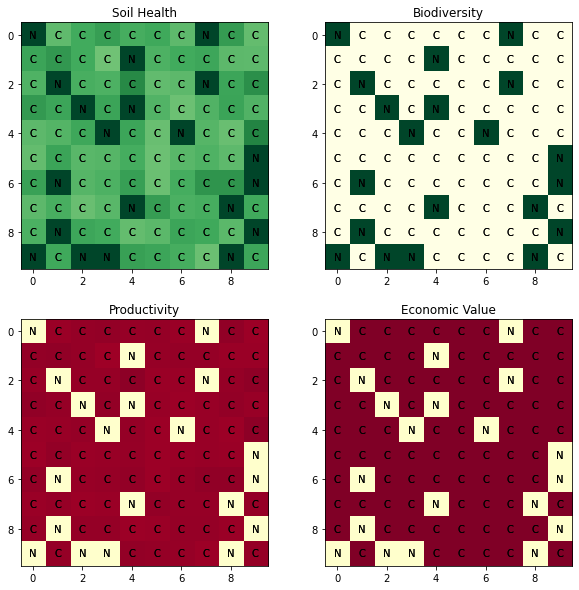

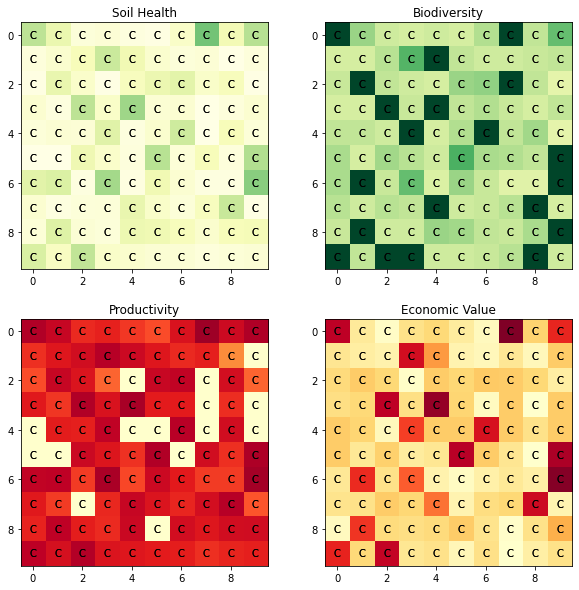

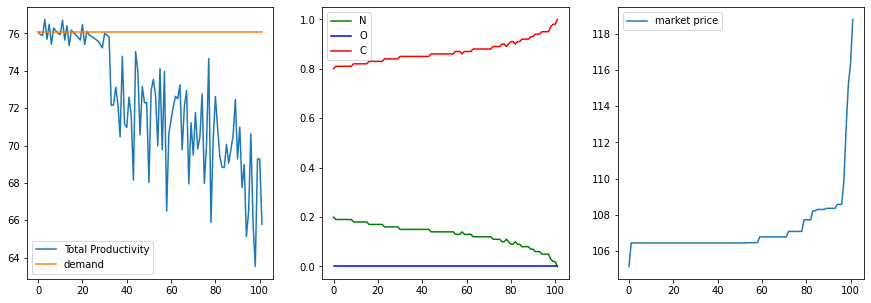

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve

np.random.seed(42)

class Landscape:
    def __init__(self, size, total_cost, frac_conventional, frac_organic, frac_natural, subsidy_strength,\
                  policy_strength_natural, mean_soil_health_agri, std_soil_health_agri, biodiversity_organic, organic_production, \
                    conventional_production, soil_health_impact, threshold_base,\
                        soil_update_organic = 0.01, soil_update_conventional = -.02, soil_update_natural=.02):
        
        self.size = size
        self.subsidy_strength = subsidy_strength
        self.policy_strength_natural = policy_strength_natural
        self.biodiversity_organic = biodiversity_organic
        self.total_cost = total_cost
        self.organic_production = organic_production
        self.conventional_production = conventional_production
        self.soil_health_impact = soil_health_impact
        self.threshold_base = threshold_base
        self.soil_update_organic = soil_update_organic
        self.soil_update_conventional = soil_update_conventional
        self.soil_update_natural = soil_update_natural

        # Initialize matrices
        if frac_conventional + frac_natural + frac_organic != 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic, frac_natural)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri)

        # Calculate initial productivity
        self.productivity = self.productionfunction()
        initial_productivity = np.sum(self.productivity)
        self.market_demand = initial_productivity
        self.market_price = self.total_cost / np.mean(self.productivity[self.land_type != 'N']) if np.mean(self.productivity[self.land_type != 'N']) > 0 else 0
        self.economic_value = self.total_cost * np.ones((size, size)) * (self.land_type != 'N')

        # Initialize data for plotting
        self.data = {'total_productivity': [], 'demand': [], 'O': [], 'C': [], 'N':[], 'market_price': [], 'total_economic_value': [], 'land_type_changes': []}

    def initialize_land_types(self, frac_conventional, frac_organic, frac_natural):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['C'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, mean, std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(mean, std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type == 'N'] = 1

        return soil_health, biodiversity
    
    def productionfunction(self):
        return self.soil_health**self.soil_health_impact * np.where(self.land_type == 'O', self.organic_production, self.conventional_production) * (self.land_type != "N")
    
    def canculata_sellingmatrix_price(self):
        # Flatten and sort the production values along with their indices
        flattened_productivity = self.productivity.ravel()
        sorted_indices = np.argsort(flattened_productivity)[::-1]
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= self.market_demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= self.market_demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if cumulative_production[meet_demand_index] > self.market_demand:
                sold_fraction[meet_demand_index] = (self.market_demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        else:
            # All units are sold
            sold_fraction[:] = 1

        # Calculate market price
        last_accepted_production = sorted_productivity[meet_demand_index]
        market_price = self.total_cost / last_accepted_production 

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction
        return reconstructed_matrix.reshape(self.productivity.shape), market_price
    
    def profit(self):

        selling_matrix, pippo = self.canculata_sellingmatrix_price()
        self.market_price = self.market_price * (1 + (self.market_demand - np.sum(selling_matrix * self.productivity)) / self.market_demand)    
        self.economic_value += (self.land_type != 'N') * (selling_matrix * self.productivity * self.market_price + np.where(self.land_type == 'O', self.subsidy_strength, 0) - self.total_cost) 
    
    def expectedprofit(self, market_price, farming_type):
        if farming_type =='O':
            return self.soil_health**self.soil_health_impact * self.organic_production * market_price + self.subsidy_strength - self.total_cost
        elif farming_type =='C':
            return self.soil_health**self.soil_health_impact * self.conventional_production * market_price - self.total_cost
        else: 
            raise AttributeError("select one type")

    def update_soil_health(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta_h = np.where(self.land_type == 'O', self.soil_update_organic, self.soil_update_conventional)
        delta_h[self.land_type == 'N'] = self.soil_update_natural
        self.soil_health += delta_h + omega * avg_neighbors
        self.land_type[self.soil_health < 0] = 'N'
        self.economic_value[self.soil_health < 0] = 0
        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')

        delta_b = np.where(self.land_type == 'N', 0.02, 0.0)
        self.biodiversity += delta_b + omega * avg_neighbors
        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def update_productivity_and_economic_value(self):
        self.productivity = self.productionfunction()        
        self.profit()
        bankrupt = self.economic_value < -1
        self.land_type[bankrupt] = 'N'
        self.economic_value[bankrupt] = 0

    def switch_farming_technique(self, gamma = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])/8
        organic_neighbors = convolve(self.land_type == 'O', kernel, mode='wrap', output=float)
        conventional_neighbors = convolve(self.land_type == 'C', kernel, mode='wrap', output=float)
        
        threshold_to_organic = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))
        threshold_to_conventional = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))

        exp_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
        exp_profit_conventional = self.expectedprofit(self.market_price, farming_type='C')
        
        switch_to_organic = (self.land_type == 'C') & ( (exp_profit_organic - exp_profit_conventional) / self.total_cost > threshold_to_organic)
        switch_to_conventional = (self.land_type == 'O') & ( (exp_profit_conventional - exp_profit_organic) / self.total_cost > threshold_to_conventional)

        self.land_type[switch_to_organic] = 'O'
        self.land_type[switch_to_conventional] = 'C'


    def introduce_new_farmers(self, policy_strenght=0.1, ):
        
        self.productivity = self.productionfunction()
        if np.any(self.land_type == 'N'):
            if (self.market_demand - np.sum(self.productivity)) > self.policy_strength_natural:
                # Select candidates
                numbers_of_new_farmers = int(min(np.sum(self.land_type == 'N'), np.ceil((self.market_demand - np.sum(self.productivity)) / np.mean(self.productivity[self.productivity > 0]))))
                candidate_list = np.argwhere(self.land_type == 'N')
                biodiversity_candidates = self.biodiversity[self.land_type == 'N'].ravel()
                probability_list = (1.1 - biodiversity_candidates**policy_strenght) / np.sum(1.1 - biodiversity_candidates**policy_strenght)
                candidate_selected = np.random.choice(np.arange(candidate_list.shape[0]), size=numbers_of_new_farmers, p=probability_list, replace=False)
                candidate_matrix = np.full((self.size, self.size), False, dtype=bool)
                candidate_matrix[candidate_list[candidate_selected][:,0], candidate_list[candidate_selected][:,1]]=True
                
                self.land_type[candidate_matrix] = 'C'
                self.economic_value[candidate_matrix] = self.total_cost

                # Choose organiv vs conventional
                # expected_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
                # expected_profit_convetional = self.expectedprofit(self.market_price, farming_type='O')
                # prob_1 = (np.sum(self.land_type == 'O')  - np.sum(self.land_type == 'C')) / (np.sum(self.land_type == 'O') + np.sum(self.land_type == 'C'))
                # prob_2 = (expected_profit_organic - expected_profit_convetional)/(expected_profit_convetional + expected_profit_organic)
                # prob_organic = 0.5 + 0.5 * prob_1 * prob_2 
                # organic = np.random.rand(self.size, self.size) < np.array(prob_organic)

                # self.land_type[candidate_matrix * organic] = 'O'
                # self.land_type[candidate_matrix * (1 - organic)] = 'C'

    def simulate_year(self):
        self.aggregate_data()
        self.update_productivity_and_economic_value()
        self.update_soil_health()
        self.update_biodiversity()
        self.switch_farming_technique()
        self.introduce_new_farmers()

        
        
    def aggregate_data(self):
        self.data['total_productivity'].append(np.sum(self.productivity))
        self.data['demand'].append(self.market_demand)
        self.data['market_price'].append(self.market_price)
        self.data['total_economic_value'].append(np.sum(self.economic_value))
        self.data['N'].append(np.sum(self.land_type=='N') / self.size**2)
        self.data['O'].append(np.sum(self.land_type=='O') / self.size**2)
        self.data['C'].append(np.sum(self.land_type=='C') / self.size**2)
        # Additional data aggregation can be added here

    def plot_aggregated_data(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        ax = axes[0]
        
        ax.plot(self.data['total_productivity'], label='Total Productivity')
        ax.plot(self.data['demand'], label = 'demand')
        ax.legend()

        ax = axes[1]
        ax.plot(self.data['N'], label='N', color='g')
        ax.plot(self.data['O'], label='O', color='b')
        ax.plot(self.data['C'], label='C', color='r')
        ax.legend()

        ax = axes[2]
        ax.plot(self.data['market_price'], label='market price')
        ax.legend()

        plt.show()

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.economic_value, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        for axes in axs.reshape(-1):
            for (j,i), label in np.ndenumerate(self.land_type):
                axes.text(i,j,label,ha='center',va='center')
                axes.text(i,j,label,ha='center',va='center')

        plt.show()

# Example usage
landscape = Landscape(size=10, total_cost=100, threshold_base=np.inf, frac_conventional=0.8, frac_organic=0., frac_natural=0.2, 
                      subsidy_strength=0, policy_strength_natural=0, 
                      mean_soil_health_agri=0.6, std_soil_health_agri=0.05, biodiversity_organic=0,
                      conventional_production=1, organic_production=0.8, soil_health_impact=0.1, soil_update_conventional=-0.01, soil_update_organic=0.)

landscape.plot_spatial_data()

for year in range(300):
    if np.all(landscape.land_type != 'N') or np.all(landscape.productivity == 0):
        break
    landscape.simulate_year()

    # print(landscape.soil_health)
landscape.aggregate_data()



landscape.plot_spatial_data()
landscape.plot_aggregated_data()



In [98]:
import numpy as np

# Given data
productivity = np.random.rand(10, 10)
demand_case_1 = 60
demand_case_2 = 30

# Step 1: Flatten and sort the production values
production_curve = np.sort(productivity.ravel())[::-1]

# Step 2 & 3: Function to calculate the fraction of production sold
def calculate_sold_fraction(production_curve, demand):
    cumulative_production = np.cumsum(production_curve)
    sold_fraction = np.zeros_like(production_curve)

    meet_demand_index = np.argmax(cumulative_production >= demand)

    # If demand is less than or equal to total production
    if cumulative_production[meet_demand_index] >= demand:
        sold_fraction[:meet_demand_index] = 1
        if cumulative_production[meet_demand_index] > demand:
            sold_fraction[meet_demand_index] = (demand - cumulative_production[meet_demand_index - 1]) / production_curve[meet_demand_index]
    else:
        sold_fraction[:] = 1

    return sold_fraction

# Calculate sold fractions for both demand cases
sold_fraction_case_1 = calculate_sold_fraction(production_curve, demand_case_1)
sold_fraction_case_2 = calculate_sold_fraction(production_curve, demand_case_2)

sold_fraction_case_1, sold_fraction_case_2


# Given cost
cost = 100

# Function to calculate market price
def calculate_market_price(production_curve, sold_fraction, cost):
    # Find the index of the last unit sold (partially or fully)
    last_sold_index = np.max(np.where(sold_fraction > 0))
    # Production value of the last unit sold
    production_value_last_unit = production_curve[last_sold_index]
    # Market price calculation
    market_price = production_value_last_unit / cost
    return market_price

# Calculate market prices for both demand cases
market_price_case_1 = calculate_market_price(production_curve, sold_fraction_case_1, cost)
market_price_case_2 = calculate_market_price(production_curve, sold_fraction_case_2, cost)

market_price_case_1, market_price_case_2



(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.73689589, 0.        , 0.        , 0.        ,
      

In [100]:
def calculate_production_sold(productivity_matrix, demand):
    """
    Calculate the fraction of production that will be sold for each entry in the productivity matrix.
    
    :param productivity_matrix: A 2D numpy array of production values.
    :param demand: The demand value to intersect with the production curve.
    :return: A 2D numpy array of the same shape as productivity_matrix, containing the sold fractions.
    """
    # Flatten and sort the production values along with their indices
    flattened_productivity = productivity_matrix.ravel()
    sorted_indices = np.argsort(flattened_productivity)[::-1]
    sorted_productivity = flattened_productivity[sorted_indices]

    # Calculate sold fractions
    sold_fraction = calculate_sold_fraction(sorted_productivity, demand)

    # Reconstruct the matrix with the sold fractions in their original positions
    reconstructed_matrix = np.zeros_like(sold_fraction)
    reconstructed_matrix[sorted_indices] = sold_fraction
    return reconstructed_matrix.reshape(productivity_matrix.shape)

# Apply this function for both demand cases
sold_matrix_combined_case_1 = calculate_production_sold(productivity, demand_case_1)
sold_matrix_combined_case_2 = calculate_production_sold(productivity, demand_case_2)

sold_matrix_combined_case_1, sold_matrix_combined_case_2


(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        , 1.        ],
        [0.        , 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 1.        ,
         1. 

In [ ]:

        # sorted_productivy = np.sort(self.productivity.ravel())[::-1]
        # last_accepted_product = np.argwhere(np.cumsum(sorted_productivy) <= self.market_demand)[-1] if np.sum(self.productivity) > self.market_demand else np.argwhere(sorted_productivy > 0)[-1][0]
        # print('TP ', np.sum(self.productivity), 'D ', self.market_demand, 'LP ', np.cumsum(sorted_productivy)[last_accepted_product], 'LPD ', last_accepted_product, 'P[LDP] ', sorted_productivy[last_accepted_product])
        # print(sorted_productivy)
        # print(np.argwhere(sorted_productivy > 0)[-1])
        # selling_matrix =  1 * (self.productivity.ravel() > sorted_productivy[last_accepted_product])
        # print(self.productivity.ravel() == sorted_productivy[last_accepted_product])
        # selling_matrix[self.productivity.ravel() == sorted_productivy[last_accepted_product]] = self.market_demand - np.cumsum(sorted_productivy[last_accepted_product])
        # selling_matrix = np.reshape(selling_matrix, (self.size, self.size))
        # print(selling_matrix[self.productivity > 0])
        # print(selling_matrix)

In [116]:
def calculate_sold_and_price_single_function(productivity_matrix, demand, cost=100):
    # Flatten and sort the production values along with their indices
    flattened_productivity = productivity_matrix.ravel()
    sorted_indices = np.argsort(flattened_productivity)[::-1]
    sorted_productivity = flattened_productivity[sorted_indices]

    # Calculate sold fractions
    cumulative_production = np.cumsum(sorted_productivity)
    sold_fraction = np.zeros_like(sorted_productivity)

    # Find the index where demand is just met or exceeded
    meet_demand_index = np.argmax(cumulative_production >= demand)

    # If demand is less than or equal to total production
    if cumulative_production[meet_demand_index] >= demand:
        # Units fully sold
        sold_fraction[:meet_demand_index] = 1
        # The last unit might be partially sold
        if cumulative_production[meet_demand_index] > demand:
            sold_fraction[meet_demand_index] = (demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
    else:
        # All units are sold
        sold_fraction[:] = 1

    # Calculate market price
    last_accepted_production = sorted_productivity[meet_demand_index]
    market_price = last_accepted_production / cost

    # Reconstruct the matrix with the sold fractions in their original positions
    reconstructed_matrix = np.zeros_like(sold_fraction)
    reconstructed_matrix[sorted_indices] = sold_fraction
    return reconstructed_matrix.reshape(productivity_matrix.shape), market_price

# Apply this combined function to the productivity matrix
production_sold_matrix_combined, market_price_combined = calculate_sold_and_price_single_function(productivity, demand_case_2)
production_sold_matrix_combined, market_price_combined


(array([[0.        , 1.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ],
        [0.00566624, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 1.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 1.        , 1.        , 0.        , 0.        ],
        [1.        , 0.    